## Laboratorium 8.2

## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---


### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:

```python
fps = source.get(cv2.CAP_PROP_FPS)
```

Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).


In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchvision.transforms.functional import to_pil_image

from IPython.display import HTML
from IPython.display import display

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.


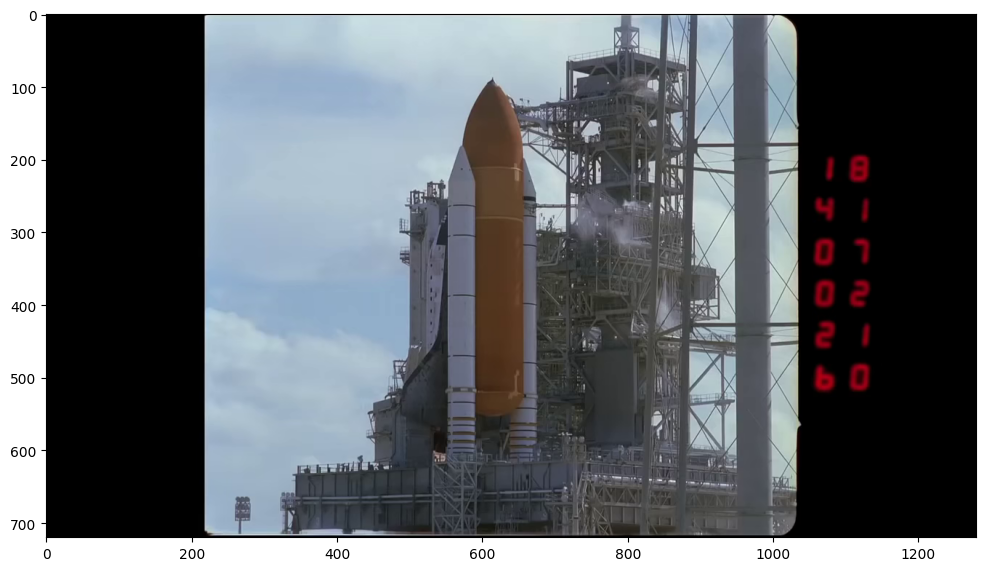

In [2]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

In [3]:
def disp_hsv_hist(image_bgr: np.ndarray):
    img_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    # display hisrogram for each channel
    plt.subplots(2, 4, figsize=(16, 12))

    plt.subplot(2, 4, 1)
    plt.hist(h.ravel(), 256, (0, 256), color="r")
    plt.title("Hue")

    plt.subplot(2, 4, 2)
    plt.hist(s.ravel(), 256, (0, 256), color="g")
    plt.title("Saturation")

    plt.subplot(2, 4, 3)
    plt.hist(v.ravel(), 256, (0, 256), color="b")
    plt.title("Value")

    plt.subplot(2, 4, 4)
    plt.hist(h.ravel(), 256, (0, 256), color="r", alpha=0.5)
    plt.hist(s.ravel(), 256, (0, 256), color="g", alpha=0.5)
    plt.hist(v.ravel(), 256, (0, 256), color="b", alpha=0.5)
    plt.legend(["Hue", "Saturation", "Value"])
    plt.title("Original Image")

    plt.subplot(2, 4, 5)
    plt.imshow(h, cmap="gray")
    plt.title("Hue")

    plt.subplot(2, 4, 6)
    plt.imshow(s, cmap="gray")
    plt.title("Saturation")

    plt.subplot(2, 4, 7)
    plt.imshow(v, cmap="gray")
    plt.title("Value")

    plt.subplot(2, 4, 8)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Image")

    plt.show()

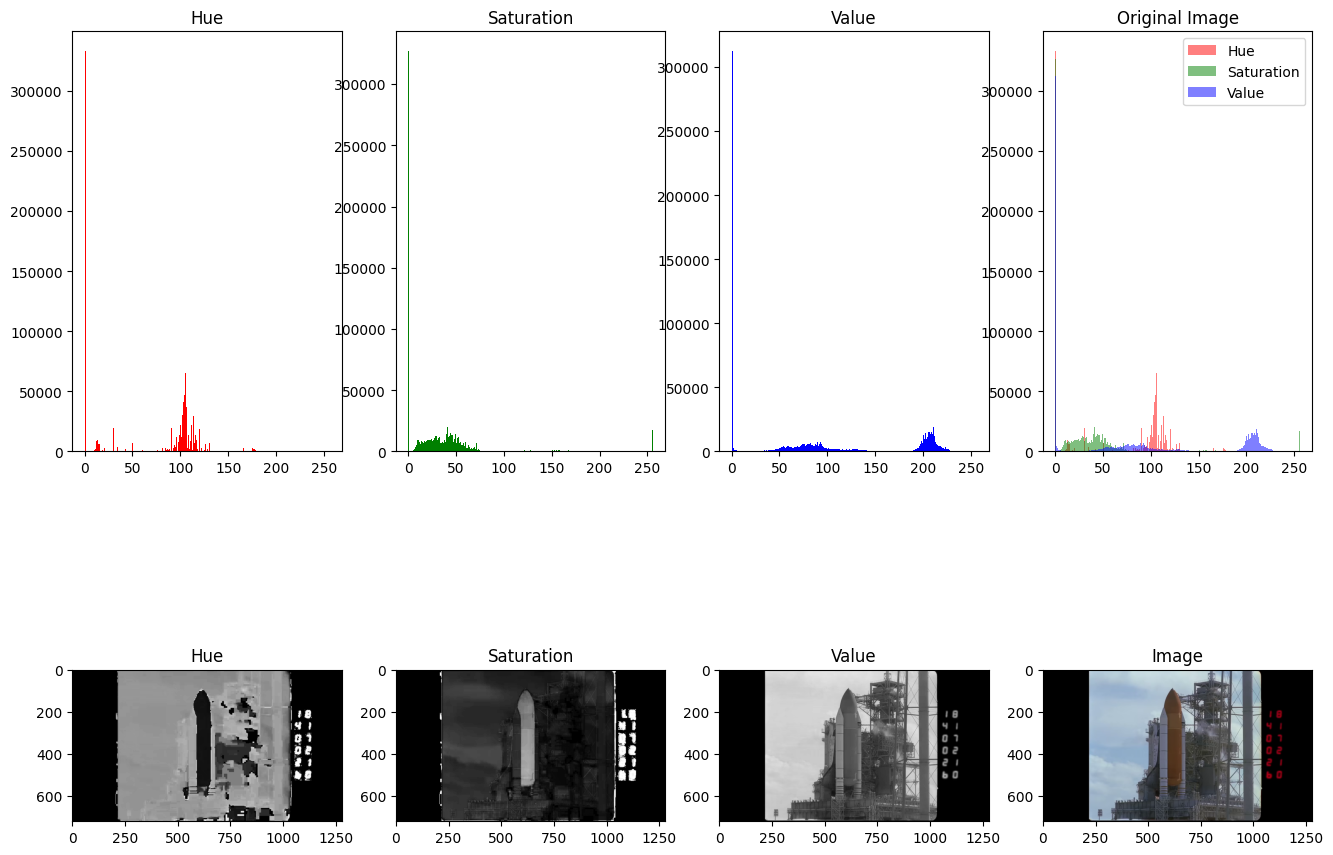

In [4]:
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(frame_hsv)
disp_hsv_hist(frame)

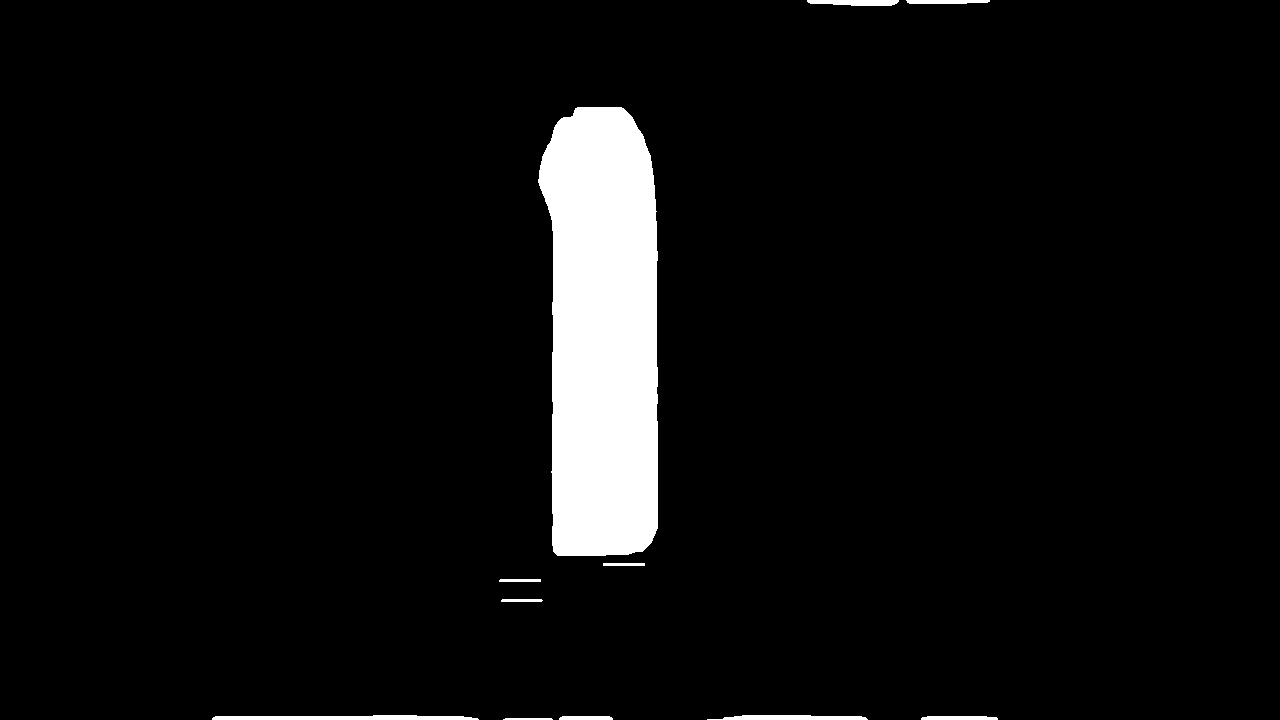

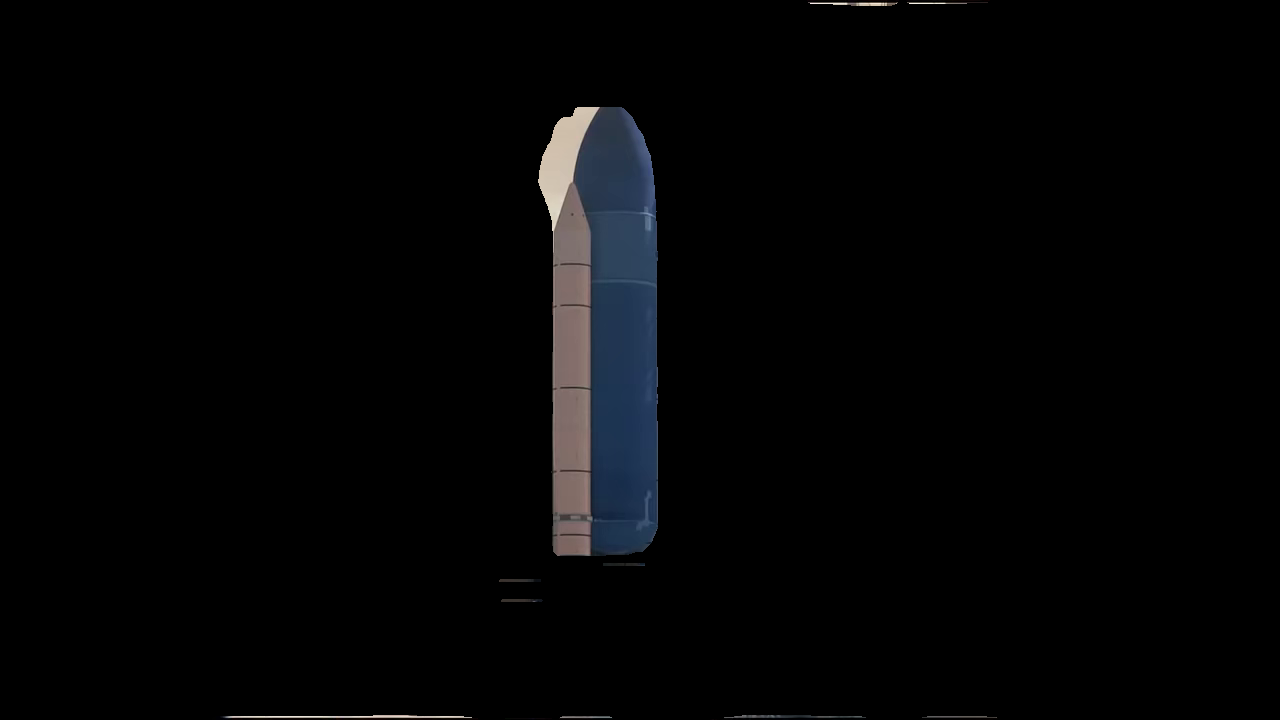

In [5]:
def get_mask(frame_bgr: np.ndarray):
    frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    frame_hsv[:, :250, :] = 0
    frame_hsv[:, 1000:, :] = 0
    s = cv2.split(frame_hsv)[1]
    s_gauss = cv2.GaussianBlur(s, (15, 15), 0)
    mask = cv2.threshold(s_gauss, 80, 1, cv2.THRESH_BINARY)[1]

    # expand horizontally
    kernel = np.ones((1, 40), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = np.roll(mask, -20, axis=1)

    return mask


mask = get_mask(frame)
display(to_pil_image(mask * 255))

frame_masked = frame * np.stack((mask, mask, mask), axis=-1)
display(to_pil_image(frame_masked))

<class 'numpy.ndarray'>
len(features)=10


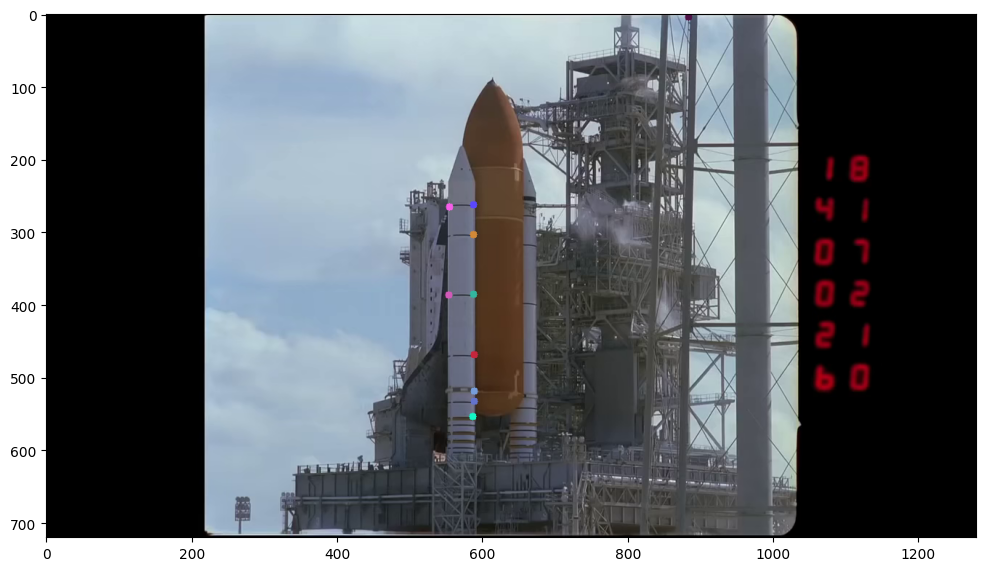

In [6]:
def get_good_features(frame: np.ndarray):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    p0 = cv2.goodFeaturesToTrack(
        gray,
        mask=mask,
        maxCorners=40,
        qualityLevel=0.15,
        minDistance=7,
        blockSize=7,
    )

    print(type(p0))
    return p0


def draw_features(features: np.ndarray, frame: np.ndarray):
    frame = frame.copy()
    features = features.astype(np.int32)

    for i in features:
        x, y = i.ravel()
        color = np.random.randint(0, 256, size=(3,))
        color = [int(channel) for channel in color]
        cv2.circle(frame, (x, y), 5, color, -1)

    _, axes = plt.subplots(1, 1, figsize=(12, 12))
    axes.imshow(frame[..., ::-1])


features = get_good_features(frame)
draw_features(features, frame)
print(f"{len(features)=}")

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).


In [7]:
from typing import Any


def base_loop_with_animation(
    source: cv2.VideoCapture,
) -> tuple[Any | None, list[Any], list[Any]]:
    frames = []
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return None, None, None

    mask = get_mask(frame_next)
    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)

    lk_params = dict(
        winSize=(17, 17),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    color = np.random.randint(0, 255, (100, 3))

    shiTomasiParams = dict(maxCorners=40, qualityLevel=0.15, minDistance=7, blockSize=7)
    p0 = cv2.goodFeaturesToTrack(frame_next_gray, mask=mask, **shiTomasiParams)
    result_img = np.zeros_like(frame_next)

    trajectories = [[] for _ in range(len(p0))]

    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)
        if p0 is None:
            break

        p1, st, _ = cv2.calcOpticalFlowPyrLK(
            frame_gray,
            frame_next_gray,
            p0,
            None,
            **lk_params,
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        # loop for each point
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            new_x, new_y = new.ravel()
            old_x, old_y = old.ravel()

            # filter out points near the picture top
            if new_y < 20 or old_y < 20:
                continue

            result_img = cv2.line(
                result_img,
                (int(new_x), int(new_y)),
                (int(old_x), int(old_y)),
                color[i].tolist(),
                2,
            )

            frame_next_result = cv2.circle(
                frame_next, (int(new_x), int(new_y)), 5, color[i].tolist(), -1
            )

            trajectories[i].append((new_x, new_y))

        img = cv2.add(frame_next_result, result_img)

        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        p0 = good_new.reshape(-1, 1, 2)

    source.release()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()
    ax.set_title("Optical Flow - Lucas-Kanade method")
    im = ax.imshow(frames[0])
    fig.tight_layout()

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = FuncAnimation(fig, update, frames=frames, interval=15, blit=True)
    plt.close(fig)

    return anim, frames, trajectories

In [8]:
# def baseLoop(source: cv2.VideoCapture):
#     frame1 = None
#     status, frame2 = source.read()
#     frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
#     # ...
#     # inicjalizacja metody
#     # ...
#     while status:
#         frame1 = frame2
#         status, frame2 = source.read()
#         frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
#         # ...
#         # przetwarzanie
#         # ...

In [9]:
source = cv2.VideoCapture("dane/shuttle.mp4")
anim, frames, trajectories = base_loop_with_animation(source)

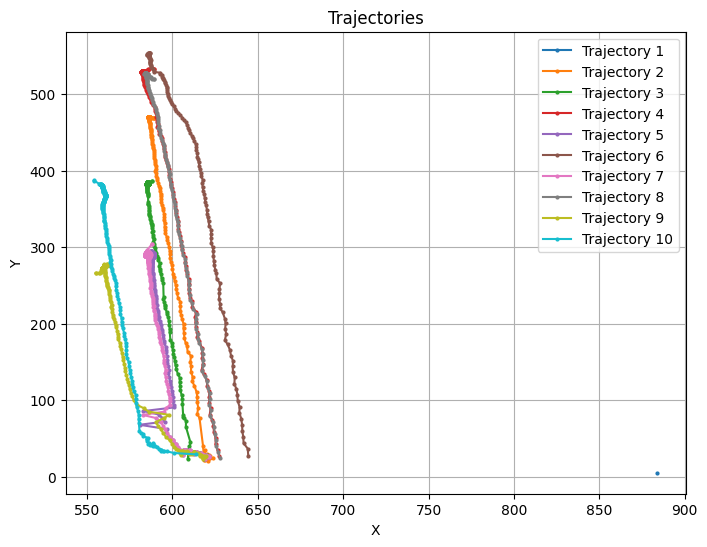

In [10]:
plt.figure(figsize=(8, 6))

for trajectory in trajectories:
    x_coords = [point[0] for point in trajectory]
    y_coords = [point[1] for point in trajectory]

    plt.plot(
        x_coords,
        y_coords,
        marker="o",
        markersize=2,
        label=f"Trajectory {trajectories.index(trajectory) + 1}",
    )

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Trajectories")
plt.legend()
plt.grid(True)

plt.show()

In [11]:
matplotlib.rcParams["animation.embed_limit"] = 40
source = cv2.VideoCapture("dane/shuttle.mp4")
fps = source.get(cv2.CAP_PROP_FPS)

html_video, frames, trajectories = base_loop_with_animation(source)
display(HTML(html_video.to_html5_video()))

In [12]:
html_video.save("output.mp4")

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.


In [13]:
print(len(trajectories))
print(trajectories[0])

10
[(np.float32(884.0), np.float32(5.0))]
